# Volume 3: ARMA Models
    <Name>
    <Class>
    <Date>

In [1]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VARMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import arma_order_select_ic as order_select
import pandas as pd

## Helper Functions

In [2]:
def kalman(F, Q, H, time_series):
    # Get dimensions
    dim_states = F.shape[0]

    # Initialize variables
    # covs[i] = P_{i | i-1}
    covs = np.zeros((len(time_series), dim_states, dim_states))
    mus = np.zeros((len(time_series), dim_states))

    # Solve of for first mu and cov
    covs[0] = np.linalg.solve(np.eye(dim_states**2) - np.kron(F,F), 
            np.eye(dim_states**2) @ Q.flatten()).reshape((dim_states,dim_states))
    mus[0] = np.zeros((dim_states,))

    # Update Kalman Filter
    for i in range(1, len(time_series)):
        # Assume u, R = 0
        SkInv = np.linalg.solve(H @ covs[i-1] @ H.T, np.eye(H.shape[0]))
        Kk_H_Pkk = covs[i-1] @ (H.T @ (SkInv @ (H @ covs[i-1])))
        covs[i] = F @ ((covs[i-1] - Kk_H_Pkk) @ F.T) + Q
        mus[i] = F @ mus[i-1] + (F @ (covs[i-1] @ (H.T @ SkInv))) @ (time_series[i-1] - H @ mus[i-1])
    return mus, covs

def state_space_rep(phis, thetas, mu, sigma):
    # Initialize variables
    dim_states = max(len(phis), len(thetas)+1)
    dim_time_series = 1 #hardcoded for 1d time_series

    F = np.zeros((dim_states,dim_states))
    Q = np.zeros((dim_states, dim_states))
    H = np.zeros((dim_time_series, dim_states))

    # Create F
    F[0,:len(phis)] = phis
    F[1:,:-1] = np.eye(dim_states - 1)
    # Create Q
    Q[0][0] = sigma**2
    # Create H
    H[0][0] = 1.
    H[0][1:len(thetas)+1] = thetas

    return F, Q, H, dim_states, dim_time_series

## Problem 1

In [3]:
def arma_forecast_naive(file='weather.npy',p=2,q=1,n=20):
    """
    Perform ARMA(p,q) on data. Let error terms be drawn from
    a standard normal, let c be 0, the phis be 0.5, and the 
    thetas be 0.1. Predict the next n observations and plot 
    the original data with the predictions.

    Parameters:
        file (str): data file
        p (int): order of autoregressive model
        q (int): order of moving average model
        n (int): number of future predictions
    """
    # initialize
    Φ_i = .5
    θ_i = .1
    z = np.zeros(n)

    # iterate
    for i in range(n):
        z[i] = Φ_i * np.sum([z[i - ps] for ps in range(p)])+ θ_i * np.sum([z[i - qs] for qs in range(q)]) + np.random.normal()
    
    return z

71


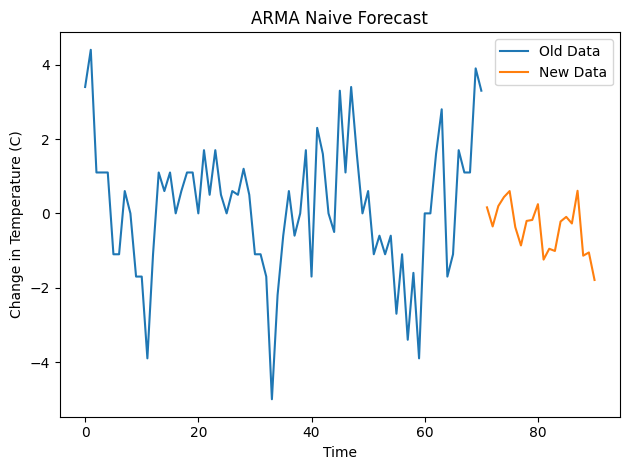

In [6]:
# load data & make time series
time_series = np.load('weather.npy')
time_series = np.diff(time_series)

# plot time series
plt.plot(time_series, label = "Old Data")
plt.xlabel("Time")
plt.ylabel("Change in Temperature (C)")

# find & print the last x value
x = len(time_series)
print(x)

# plot the forecasted next 20 values
plt.plot( np.arange(x, x+20), arma_forecast_naive(n=20), label = "New Data")
plt.legend()
plt.title('ARMA Naive Forecast')
plt.tight_layout()
plt.show()

## Problem 2

In [19]:
def arma_likelihood(filename='weather.npy', phis=np.array([0.9]), thetas=np.array([0]), mu=17., std=0.4):
    """
    Transfer the ARMA model into state space.
    Return the log-likelihood of the ARMA model.

    Parameters:
        file (str): data file
        phis (ndarray): coefficients of autoregressive model
        thetas (ndarray): coefficients of moving average model
        mu (float): mean of errorm
        std (float): standard deviation of error

    Return:
        log_likelihood (float)
    """
    # state space representation
    F, Q, H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)

    # get time series & make it stationary
    time_series = np.load(filename)
    z = np.diff(time_series) - mu

    # set up Kalman filter
    mus, covs = kalman(F, Q, H, z)

    # compute log likelihood
    log_likelihood = sum(norm.logpdf(z[i], loc=H.dot(mus[i]), scale=np.sqrt(H.dot(covs[i]).dot(H.T))) for i in range(len(z)))

    return log_likelihood[0][0]

In [20]:
arma_likelihood(filename='weather.npy', phis=np.array([0.9]),
                    thetas=np.array([0]), mu=17., std=0.4)

-1375.1805469978776

## Problem 3

In [24]:
def model_identification(filename='weather.npy',p_max=4,q_max=4):
    """
    Identify parameters to minimize AIC of ARMA(p,q) model

    Parameters:
        file (str): data file
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model

    Returns:
        phis (ndarray (p,)): coefficients for AR(p)
        thetas (ndarray (q,)): coefficients for MA(q)
        mu (float): mean of error
        std (float): std of error
    """
    # get time series& make it stationary
    time_series = np.load(filename)
    z = np.diff(time_series)

    # initialize variables
    AIC = np.zeros((p_max+1,q_max+1))
    phis, thetas, mu, std = {}, {}, {}, {}

    def aic(k, log_likelihood):
        return 2*k*(1 + (k + 1)/(len(z) - k)) - 2*log_likelihood

    # iterate through all possible models
    for p in range(1, p_max+1):
        for q in range(1, q_max+1):
            k = p + q + 2

            # find maximum log_likelihood
            def f(x):
                return -1*arma_likelihood(filename, phis=x[:p], thetas=x[p:p+q], mu=x[-2], std=x[-1])

            # construct initial point
            x0 = np.zeros(p + q + 2)
            x0[-2] = time_series.mean()
            x0[-1] = time_series.std()
            sol = minimize(f, x0, method = "SLSQP")
            sol = sol['x']

            # calculate log likelihood & AIC
            log_likelihood = arma_likelihood(filename, phis=sol[:p], thetas=sol[p:p+q], mu=sol[-2], std=sol[-1])
            AIC[p,q] = aic(k, log_likelihood)

            # get phis & thetas
            phis[(p, q)] = sol[:p]
            thetas[(p, q)] = sol[p:p+q]
            mu[(p, q)] = sol[-2]
            std[(p, q)] = sol[-1]

    # calc minimum AIC
    min_aic = np.min(AIC)
    min_aic_index = np.where(AIC == min_aic)
    p = min_aic_index[0][0]
    q = min_aic_index[1][0]

    p += 1
    q += 1
    
    return phis[(p,q)], thetas[(p,q)], mu[(p, q)], std[(p, q)]
    

In [25]:
model_identification(filename='weather.npy', p_max=4, q_max=4)

/var/folders/wy/4kq_1xrj7fz3yq5m_n6b14t40000gn/T/ipykernel_38678/3885787093.py:27: RuntimeWarning: invalid value encountered in sqrt
  log_likelihood = sum(norm.logpdf(z[i], loc=H.dot(mus[i]), scale=np.sqrt(H.dot(covs[i]).dot(H.T))) for i in range(len(z)))


(array([0.72136998]),
 array([-0.26247815]),
 0.3598476912427145,
 1.5568582097758676)

## Problem 4

In [27]:
def arma_forecast(filename='weather.npy', phis=np.array([0]), thetas=np.array([0]), mu=0, std=0, n=30):
    """
    Forecast future observations of data.

    Parameters:
        file (str): data file
        phis (ndarray (p,)): coefficients of AR(p)
        thetas (ndarray (q,)): coefficients of MA(q)
        mu (float): mean of ARMA model
        std (float): standard deviation of ARMA model
        n (int): number of forecast observations
    """

    # Get state space representation
    F, Q, H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)

    # Get time series
    time_series = np.load(filename)

    # Make time series stationary
    z = np.diff(time_series) - mu

    # Get Kalman Filter
    x_k, P_k = kalman(F, Q, H, z)

    # use the update step on the last elements of z, mus, and covs to find new_mus, new_covs
    # iteratovely use predict step for future predictions of mus and covs

    new_mus = []
    new_covs = []

    # update step
    y_k = z[-1] - H.dot(x_k[-1])
    S_k = H.dot(P_k[-1]).dot(H.T)
    K_k = P_k[-1].dot(H.T).dot(np.linalg.inv(S_k))
    x_k_new = x_k[-1] + K_k.dot(y_k)
    P_k_new = P_k[-1] - K_k.dot(H).dot(P_k[-1])

    for i in range(n):
        # predict
        x_k_new = F.dot(x_k_new)
        P_k_new = F.dot(P_k_new).dot(F.T) + Q

        new_mu = H.dot(x_k_new) + mu
        new_cov = H.dot(P_k_new).dot(H.T)

        # append new mu and cov
        new_mus.append(new_mu)
        new_covs.append(new_cov)

    # set up
    M, C = np.array(new_mus), np.array(new_covs).flatten()
    n = len(M)
    t = len(z)
    domain = np.linspace(13 + 19/24, (331 + t)/24, t)
    future_domain = np.linspace((332 + t)/24, (332 + t + n)/24, n)
    
    # set up confidence interval 
    lower = [m - 1.96*np.sqrt(c) for m, c in zip(M, C)]
    upper = [m + 1.96*np.sqrt(c) for m, c in zip(M, C)]
    
    # plot
    plt.plot(domain, z, label='old data')
    plt.plot(future_domain, M, '-.', label='forecast')
    plt.plot(future_domain, upper, color='green', label='upper bound')
    plt.plot(future_domain, lower, color='green', label='lower bound')
    plt.xlabel('Time')
    plt.ylabel("Change in Temperature (C)")
    plt.title('ARMA Forecast')
    plt.legend()
    plt.show()


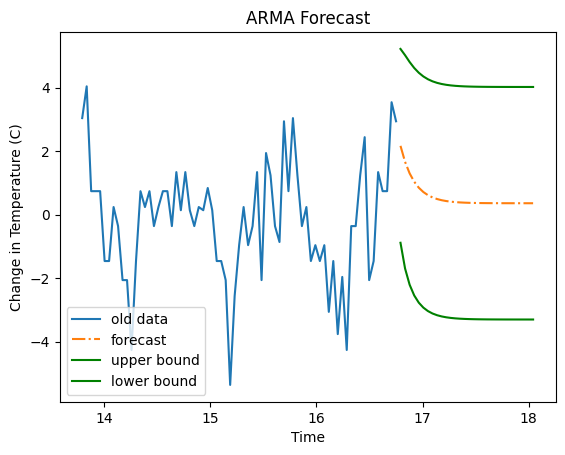

In [28]:
# set up inputs
phis, thetas, mu, std = np.array([0.72135856]), np.array([-0.26246788]), 0.35980339870105321, 1.5568331253098422
# forecast
arma_forecast(filename='weather.npy', phis=phis, thetas=thetas, mu=mu, std=std, n=30)

## Problem 5

In [31]:
def sm_arma(filename='weather.npy', p_max=3, q_max=3, n=30):
    """
    Build an ARMA model with statsmodel and
    predict future n values.

    Parameters:
        filename (str): data filename
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model
        n (int): number of values to predict

    Return:
        aic (float): aic of optimal model
    """
    # load the time series data & make it stationary
    time_series = np.load(filename)
    z = np.diff(time_series)

    # initialize AIC storage
    AIC = np.full((p_max+1, q_max+1), np.inf)

    # Model evaluation and selection
    for p in range(p_max+1):
        for q in range(q_max+1):
            try:
                model = ARIMA(z, order=(p,0,q), trend='c').fit(method='innovations_mle')
                AIC[p, q] = model.aic
            except:
                continue

    # identify the optimal model
    p_opt, q_opt = np.divmod(AIC.argmin(), q_max+1)
    optimal_model = ARIMA(z, order=(p_opt,0,q_opt), trend='c').fit(method='innovations_mle')

    # plot original observations and forecasts
    domain = np.linspace(13 + 19/24, (331 + len(z))/24, len(z))
    predictions = optimal_model.predict(start=0, end=len(z)+n-1)
    future_domain = np.linspace(13 + 19/24, (332 + len(predictions))/24, len(predictions))

    plt.plot(domain, z, label='Original Observations')
    plt.plot(future_domain, predictions, label='Forecast Observations')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel("Change in Temperature (C)")
    plt.title('ARMA Forecast')
    plt.show()

    return optimal_model.aic

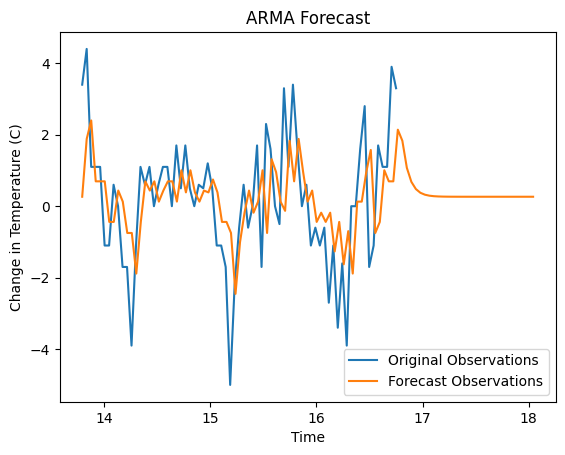

272.3509732988569

In [32]:
sm_arma()

## Problem 6

In [42]:
def sm_varma(start='1959-09-30', end='2012-09-30'):
    """
    Build an VARMAX model with statsmodel and
    forecast from start date until end date.

    Parameters:
        start (str): the data at which to begin forecasting
        end (str): the date at which to stop forecasting

    Return:
        aic (float): aic of optimal model
    """
    # load in data
    df = sm.datasets.macrodata.load_pandas().data
    
    # create DatetimeIndex
    dates = df[['year', 'quarter']].astype(int).astype(str)
    dates = dates["year"] + "Q" + dates["quarter"]
    dates = dates_from_str(dates)
    df.index = pd.DatetimeIndex(dates)

    # choose the columns used in prediction
    df = df[['realgdp','realcons','realinv']]

    # initialize the model & fit using aic
    model = VARMAX(df, freq='Q-DEC')
    model_fit = model.fit(maxiter=1000, disp=False, ic='aic')

    # predict & forecast
    predictions = model_fit.predict(start, end)
    forecast = model_fit.get_forecast(end)

    # get the confidence interval
    conf_int = forecast.conf_int(alpha = 0.05)

    # plot original data, prediction, and confidence interval for each variable
    for i in range(len(df.columns)):
        plt.plot(df.index, df.iloc[:,i], label='Original Data')
        plt.plot(predictions.index, predictions.iloc[:,i], label='Predicted Data')
        plt.plot(conf_int.index, conf_int.iloc[:,i], label='Confidence Interval')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel(df.columns[i])
        plt.title(f'ARMA Forecast {i+1}')
        plt.show()

/Users/brynnwoolley/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = endog.fillna(method='backfill').values
/Users/brynnwoolley/anaconda3/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: ic. After release 0.14, this will raise.
  warnings.warn(


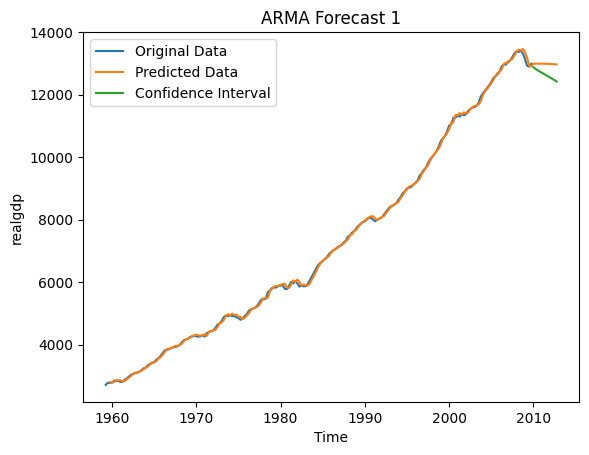

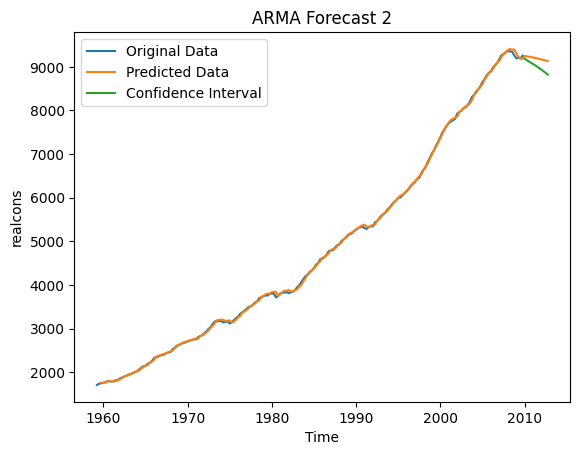

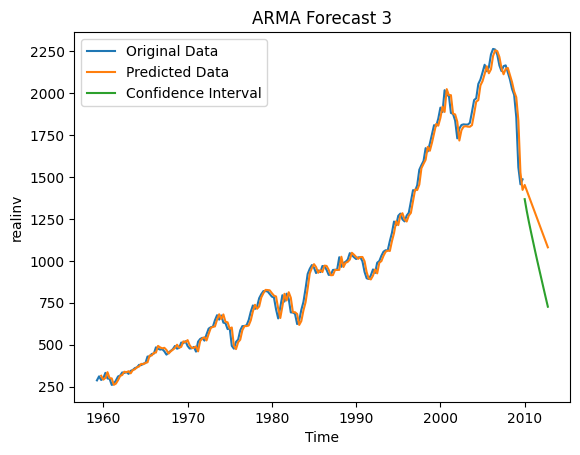

In [43]:
sm_varma()